In [26]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime
import warnings
import torch
from torch import nn
warnings.filterwarnings('ignore')

In [27]:
df = pd.read_csv('PM2.5.csv')

In [28]:
df["Date"] = pd.to_datetime(df[['year', 'month', 'day']])
#df = df[df.Date.dt.date>=datetime.date(2014,1,1)]
data = df.groupby(df.Date)['pm2.5'].mean()
data = pd.DataFrame(data)
data.dropna(inplace=True)
data = data.astype('int')

In [29]:
from statsmodels.tsa import stattools
import statsmodels.api as sm

(-22.568983684659827, 0.0, 0, 1788, {'1%': -3.43401259115756, '5%': -2.863157830275956, '10%': -2.567631281336176}, 19975.974751307625)


<AxesSubplot:xlabel='Date'>

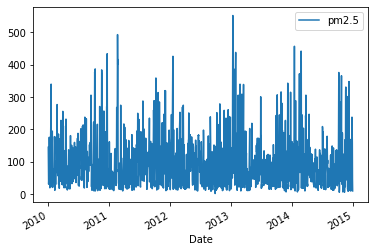

In [30]:
print(stattools.adfuller(data['pm2.5'],0))
data.plot()

(-46.430212575631344, 0.0, 0, 1787, {'1%': -3.4340146436883665, '5%': -2.8631587363584567, '10%': -2.5676317637986714}, 20397.505732212037)


<AxesSubplot:xlabel='Date'>

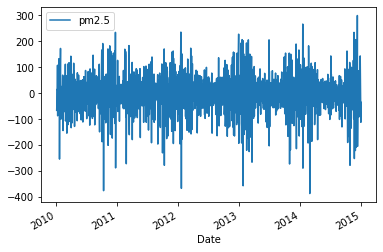

In [31]:
diff_1=data.diff(1)
diff1=diff_1.dropna()
print(stattools.adfuller(diff1['pm2.5'],0))
diff1.plot()

In [32]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(diff1,lags=1)

,lb_stat,lb_pvalue
1,15.793153,0.000071


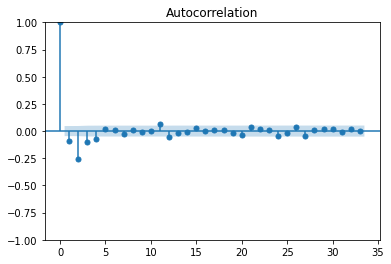

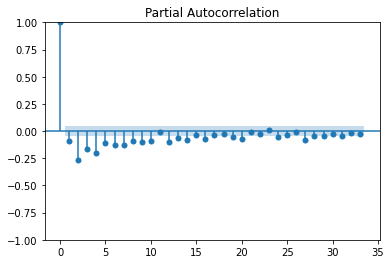

In [33]:
#求差分序列的自相关图ACF和偏自相关图PACF
sm.graphics.tsa.plot_acf(diff1)
sm.graphics.tsa.plot_pacf(diff1);

In [34]:
#sm.tsa.arma_order_select_ic(diff1['pm2.5'],max_ar=10,max_ma=10,ic='aic')

In [35]:
train_size = int(len(data) * 0.9)
test_size = len(data) - train_size
train = data[:train_size]
test = data[-test_size:]
arima_model = sm.tsa.ARIMA(data,order=(2,1,3)).fit()

In [36]:
arima_model.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  pm2.5   No. Observations:                 1789
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -9958.847
Date:                Mon, 03 Jan 2022   AIC                          19929.693
Time:                        15:12:23   BIC                          19962.626
Sample:                             0   HQIC                         19941.854
                               - 1789                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6263      0.030    -20.958      0.000      -0.685      -0.568
ar.L2          0.3569      0.028     12.761      0.000       0.302       0.412
ma.L1          0.2873      0.211      1.361      0.173      -0.126       0.701
ma.L2         -1.0000      0.066    -15.134      0.000      -1.129      -0.870
ma.L3         -0.2873      0.036     -8.032      0.000      -0.357      -0.217
sigma2      4010.6197   7.22e-05   5.55e+07      0.000    4010.620    4010.620
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               414.96
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                             0.68
Prob(H) (two-sided):                  0.36   Kurtosis:                         4.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.42e+23. Standard errors may be unstable.
"""

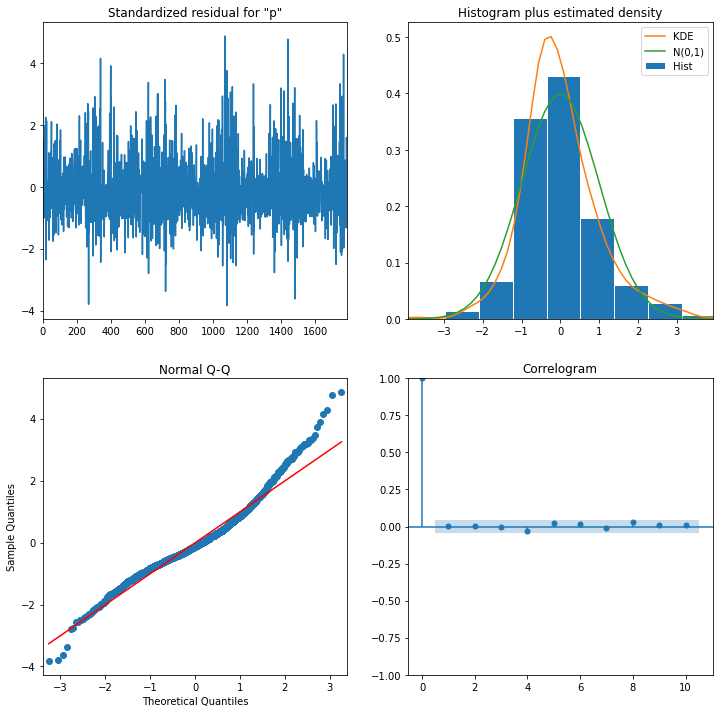

In [37]:
arima_model.plot_diagnostics(figsize=(12, 12))
plt.show()

In [38]:
predictions_ARIMA = arima_model.fittedvalues

MSE: 4029.002


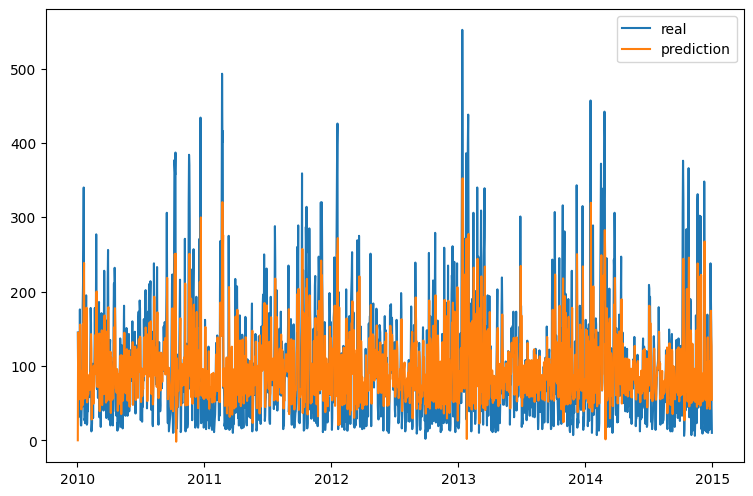

In [39]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(data[1:], predictions_ARIMA[1:])
print('MSE: %.3f' % error)

fig = plt.figure(figsize=(9,6), dpi=100)
ax = fig.add_subplot(111)
# 绘图
ax.plot(data, label='real')
ax.plot(predictions_ARIMA, label='prediction')
ax.legend()# 图例
plt.show()

In [44]:
pred = arima_model.predict('20140706', '20141230',dynamic=True)

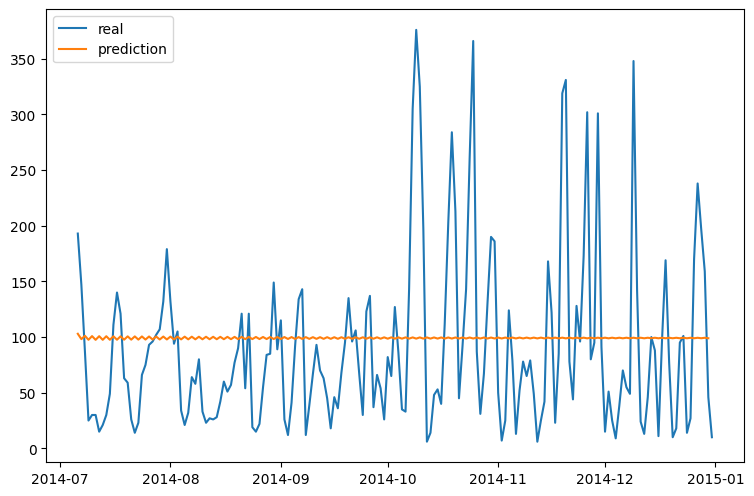

In [47]:
fig = plt.figure(figsize=(9,6), dpi=100)
ax = fig.add_subplot(111)
# 绘图
ax.plot(test, label='real')
ax.plot(pred, label='prediction')
ax.legend()# 图例
plt.show()

In [48]:
inf = int(data.min())
sup = int(data.max())
data = list(data['pm2.5'])
scale = sup - inf
data = list(map(lambda x: (x - inf)/ scale,data))

AttributeError: 'list' object has no attribute 'min'

In [49]:
NUMBER_FOR_TRAIN =  14

def create_dataset(data, number_for_train=7) -> (np.array, np.array):
    """
        根据给定的序列data，生成数据集
        
        数据集分为输入和输出，每一个输入的长度为number_for_train，每一个输出的长度为1。
        也就是说用number_for_train天的数据，对应下一天的数据。

        若给定序列的长度为d，将输出长度为(d-number_for_train+1)个输入/输出对
    """
    dataset_x, dataset_y= [], []
    for i in range(len(data)-number_for_train):
        _x = data[i:(i+number_for_train)]
        dataset_x.append(_x)
        dataset_y.append(data[i+number_for_train])
    return (np.array(dataset_x), np.array(dataset_y))

dataset_x, dataset_y = create_dataset(data, NUMBER_FOR_TRAIN)

# 划分训练集和测试集，70%作为训练集
train_size = int(len(dataset_x) * 0.9)

train_x = dataset_x[:train_size]
train_y = dataset_y[:train_size]
test_x = dataset_x[train_size:]

# 将数据改变形状，RNN 读入的数据维度是 (seq_size, batch_size, feature_size)
train_x = train_x.reshape(-1, 1, NUMBER_FOR_TRAIN)
train_y = train_y.reshape(-1, 1, 1)


# 转为pytorch的tensor对象
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
train_x = torch.from_numpy(train_x).to(dev)
train_y = torch.from_numpy(train_y).to(dev)
train_x = train_x.to(torch.float32)
train_y = train_y.to(torch.float32)
dataset_x = dataset_x.reshape(-1, 1, NUMBER_FOR_TRAIN)  # (seq_size, batch_size, feature_size)
dataset_x = torch.from_numpy(dataset_x)
dataset_x = dataset_x.to(torch.float32).to(dev)
test_x = test_x.reshape(-1, 1, NUMBER_FOR_TRAIN)  # (seq_size, batch_size, feature_size)
test_x = torch.from_numpy(test_x)
test_x = test_x.to(torch.float32).to(dev)

In [50]:
from torch import nn
class LSTM_Regression(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, _x):
        x, _ = self.lstm(_x)  # _x is input, size (seq_len, batch, input_size)
        s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
        x = x.view(s*b, h)
        x = self.fc(x)
        x = x.view(s, b, -1)  # 把形状改回来
        return x
lstm_model = LSTM_Regression(NUMBER_FOR_TRAIN, 10, output_size=1, num_layers=2)
lstm_model.to(dev)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-2)

for i in range(5000):                   
    out = lstm_model(train_x)
    loss = loss_function(out, train_y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if (i+1) % 1000 == 0:
        print('Epoch: {}, Loss:{:.5f}'.format(i+1, loss.item()))

Epoch: 1000, Loss:0.00808
Epoch: 2000, Loss:0.00575
Epoch: 3000, Loss:0.00473
Epoch: 4000, Loss:0.00378
Epoch: 5000, Loss:0.00351


In [51]:
lstm_model = lstm_model.eval() # 转换成测试模式
# 注意这里用的是全集 模型的输出长度会比原数据少DAYS_FOR_TRAIN 填充使长度相等再作图
pred = lstm_model(dataset_x).cpu() # 全量训练集的模型输出 (seq_size, batch_size, output_size)
pred = pred.view(-1).data.numpy()

MSE: 0.00512
MSE: 1549.21849


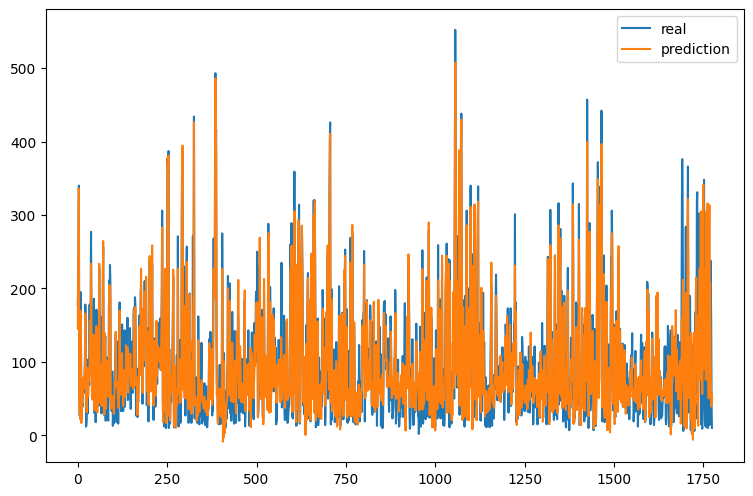

In [52]:
real = data[NUMBER_FOR_TRAIN:]

error = mean_squared_error(real, pred)
print('MSE: %.5f' % error)

for i in range(len(real)):
    real[i] = real[i]*scale + inf
for i in range(len(real)):
    pred[i] = pred[i]*scale + inf


error = mean_squared_error(real, pred)
print('MSE: %.5f' % error)


# 图片大小设置
fig = plt.figure(figsize=(9,6), dpi=100)
ax = fig.add_subplot(111)
# 绘图
ax.plot(real, label='real')
ax.plot(pred, label='prediction')
ax.legend()# 图例
plt.show()

MSE: 0.02595
MSE: 7850.50976


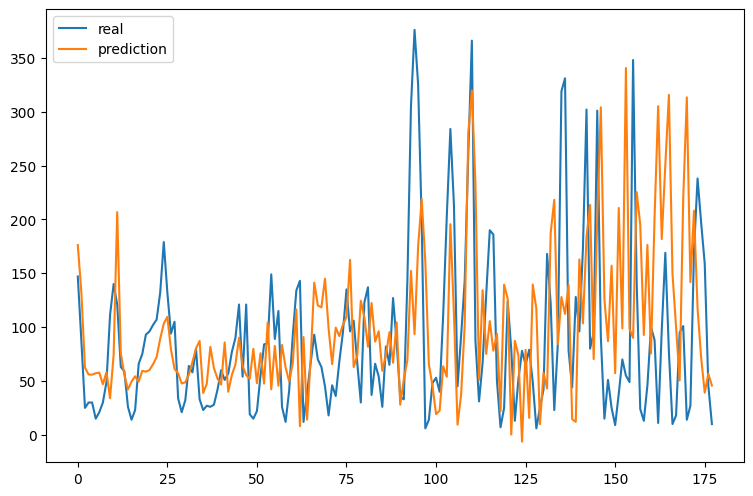

In [53]:
pred_test = lstm_model(test_x).cpu() # 全量训练集的模型输出 (seq_size, batch_size, output_size)
pred_test = pred_test.view(-1).data.numpy()
real_test = data[NUMBER_FOR_TRAIN+train_size:]

error = mean_squared_error(real_test, pred_test)
print('MSE: %.5f' % error)

for i in range(len(real_test)):
    real_test[i] = real_test[i]*scale + inf
for i in range(len(real_test)):
    pred_test[i] = pred_test[i]*scale + inf


error = mean_squared_error(real_test, pred_test)
print('MSE: %.5f' % error)


# 图片大小设置
fig = plt.figure(figsize=(9,6), dpi=100)
ax = fig.add_subplot(111)
# 绘图
ax.plot(real_test, label='real')
ax.plot(pred_test, label='prediction')
ax.legend()# 图例
plt.show()